In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [2]:
dataset_path = "./PlantVillage"  

img_size = 224
batch_size = 32

print(f"Dataset Path Set: {dataset_path}")
print(f"Image Size: {img_size}x{img_size}, Batch Size: {batch_size}")

Dataset Path Set: ./PlantVillage
Image Size: 224x224, Batch Size: 32


In [3]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training Data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

# Validation Data
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
)

# Print classes to verify
print("Classes found:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)
print(f"Number of Classes: {num_classes}")

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Classes found: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}
Number of Classes: 15


Run this cell only once to save the validation images in a folder

In [12]:
import os
import shutil

save_path = './validation_images'
os.makedirs(save_path, exist_ok=True)

class_indices = val_generator.class_indices
classes = {v: k for k, v in class_indices.items()}

for i in range(len(val_generator.filenames)):
    # Get class name and image path
    img_path = os.path.join(dataset_path, val_generator.filenames[i])
    class_name = val_generator.filenames[i].split(os.path.sep)[0]

    # Create class folder if it doesn't exist
    class_folder = os.path.join(save_path, class_name)
    os.makedirs(class_folder, exist_ok=True)

    # Extract image name
    img_name = os.path.basename(img_path)
    
    # Copy the image to the class folder
    shutil.copy(img_path, os.path.join(class_folder, img_name))

print("Validation images saved successfully in './validation_images' folder.")



Validation images saved successfully in './validation_images' folder.


In [36]:
# Load MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3),include_top=False,weights='imagenet')
base_model.trainable = False  # Freeze all layers initially
print("Base model loaded and frozen.")

Base model loaded and frozen.


In [37]:
# Custom Model on top of MobileNetV2
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Model compiled successfully.")

Model compiled successfully.


In [7]:
# Make directory for saving models if not exists
os.makedirs("saved_models", exist_ok=True)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'saved_models/mobilenet_finetuned_best2.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

print("\nCallbacks for early stopping and model checkpointing are set.")


Callbacks for early stopping and model checkpointing are set.


In [39]:
# Train the model with frozen base first
history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[early_stopping, checkpoint])
print("\nInitial training with frozen base completed.")

Epoch 1/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5802 - loss: 1.3446

517/517 ━━━━━━━━━━━━━━━━━━━━ 1483s 3s/step - accuracy: 0.5805 - loss: 1.3438 - val_accuracy: 0.8416 - val_loss: 0.4894
Epoch 2/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8099 - loss: 0.5608

517/517 ━━━━━━━━━━━━━━━━━━━━ 812s 2s/step - accuracy: 0.8100 - loss: 0.5608 - val_accuracy: 0.8680 - val_loss: 0.3975
Epoch 3/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8427 - loss: 0.4658

517/517 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.8427 - loss: 0.4659 - val_accuracy: 0.8772 - val_loss: 0.3630
Epoch 4/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8538 - loss: 0.4344

517/517 ━━━━━━━━━━━━━━━━━━━━ 766s 1s/step - accuracy: 0.8538 - loss: 0.4344 - val_accuracy: 0.8913 - val_loss: 0.3376
Epoch 5/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8568 - loss: 0.4209

517/517 ━━━━━━━━━━━━━━━━━━━━ 760s 1s/step - accuracy: 0.8568 - loss: 0.4209 - val_accuracy: 0.8930 - val_loss: 0.3063
Epoch 6/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 838s 2s/step - accuracy: 0.8737 - loss: 0.3932 - val_accuracy: 0.8814 - val_loss: 0.3305
Epoch 7/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 676s 1s/step - accuracy: 0.8741 - loss: 0.3636 - val_accuracy: 0.8836 - val_loss: 0.3269
Epoch 8/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8800 - loss: 0.3530

517/517 ━━━━━━━━━━━━━━━━━━━━ 931s 2s/step - accuracy: 0.8800 - loss: 0.3530 - val_accuracy: 0.8967 - val_loss: 0.2948
Epoch 9/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 1224s 2s/step - accuracy: 0.8854 - loss: 0.3397 - val_accuracy: 0.8952 - val_loss: 0.3118
Epoch 10/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 1069s 2s/step - accuracy: 0.8812 - loss: 0.3553 - val_accuracy: 0.8935 - val_loss: 0.3048
Epoch 11/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8864 - loss: 0.3299

517/517 ━━━━━━━━━━━━━━━━━━━━ 987s 2s/step - accuracy: 0.8864 - loss: 0.3299 - val_accuracy: 0.9010 - val_loss: 0.2809
Epoch 12/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8900 - loss: 0.3268

517/517 ━━━━━━━━━━━━━━━━━━━━ 710s 1s/step - accuracy: 0.8900 - loss: 0.3268 - val_accuracy: 0.9039 - val_loss: 0.2772
Epoch 13/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.8940 - loss: 0.3067

517/517 ━━━━━━━━━━━━━━━━━━━━ 647s 1s/step - accuracy: 0.8940 - loss: 0.3067 - val_accuracy: 0.9073 - val_loss: 0.2794
Epoch 14/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 654s 1s/step - accuracy: 0.8874 - loss: 0.3158 - val_accuracy: 0.9039 - val_loss: 0.2687
Epoch 15/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8926 - loss: 0.3055

517/517 ━━━━━━━━━━━━━━━━━━━━ 671s 1s/step - accuracy: 0.8926 - loss: 0.3055 - val_accuracy: 0.9100 - val_loss: 0.2673

Initial training with frozen base completed.


After login, start running below cells onwards

In [8]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model('saved_models/mobilenet_finetuned_best2.h5')
print("Best model loaded for fine-tuning.")

Best model loaded for fine-tuning.


In [9]:
# Unfreeze last few layers of base model for fine-tuning
model.trainable = True

# Freeze all layers except the last 30
for layer in model.layers[:-20]:
    layer.trainable = False

print("\nLast 30 layers of the base model are now trainable for fine-tuning.")


Last 30 layers of the base model are now trainable for fine-tuning.


In [10]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print("\nModel recompiled with slightly higher learning rate for fine-tuning.")


Model recompiled with slightly higher learning rate for fine-tuning.


In [11]:
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stopping, checkpoint]
)

print("\nFine-tuning completed.")

c:\Users\rahul\anaconda3\envs\plant-disease\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9140 - loss: 0.2420

517/517 ━━━━━━━━━━━━━━━━━━━━ 1127s 2s/step - accuracy: 0.9140 - loss: 0.2420 - val_accuracy: 0.9180 - val_loss: 0.2265
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9197 - loss: 0.2323

517/517 ━━━━━━━━━━━━━━━━━━━━ 895s 2s/step - accuracy: 0.9197 - loss: 0.2323 - val_accuracy: 0.9187 - val_loss: 0.2338
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.9165 - loss: 0.2437

517/517 ━━━━━━━━━━━━━━━━━━━━ 636s 1s/step - accuracy: 0.9165 - loss: 0.2437 - val_accuracy: 0.9202 - val_loss: 0.2248
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.9206 - loss: 0.2323

517/517 ━━━━━━━━━━━━━━━━━━━━ 635s 1s/step - accuracy: 0.9206 - loss: 0.2323 - val_accuracy: 0.9253 - val_loss: 0.2235
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 632s 1s/step - accuracy: 0.9222 - loss: 0.2305 - val_accuracy: 0.9209 - val_loss: 0.2195

Fine-tuning completed.


In [12]:
# Evaluate after fine-tuning
final_loss, final_accuracy = model.evaluate(val_generator)
print(f"\nFinal Validation Accuracy (After Fine-Tuning): {final_accuracy:.4f}")
print(f"Final Validation Loss (After Fine-Tuning): {final_loss:.4f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 126s 976ms/step - accuracy: 0.9190 - loss: 0.2333

Final Validation Accuracy (After Fine-Tuning): 0.9238
Final Validation Loss (After Fine-Tuning): 0.2235


Evaluate the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction Confidence: 0.9535
Actual Class: Tomato_Bacterial_spot
Predicted Class: Tomato_Bacterial_spot


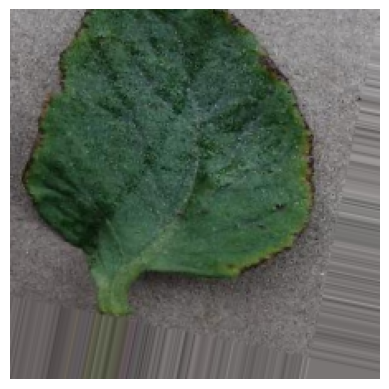

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('saved_models/mobilenet_finetuned_best2.h5')

# Get class labels from the generator
class_labels = {v: k for k, v in val_generator.class_indices.items()}

# Get a random batch from val_generator
images, labels = next(val_generator)
random_index = np.random.randint(len(images))

# Select random image and its actual class
img = images[random_index]
actual_class_index = np.argmax(labels[random_index])
actual_class_name = class_labels[actual_class_index]

# Predict using the model
img_expanded = np.expand_dims(img, axis=0)
prediction = model.predict(img_expanded)
confidence = np.max(prediction)
print(f"Prediction Confidence: {confidence:.4f}")
predicted_class_index = np.argmax(prediction)
predicted_class_name = class_labels[predicted_class_index]

# Display the image and prediction
plt.imshow(img)
plt.axis('off')
print(f"Actual Class: {actual_class_name}")
print(f"Predicted Class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

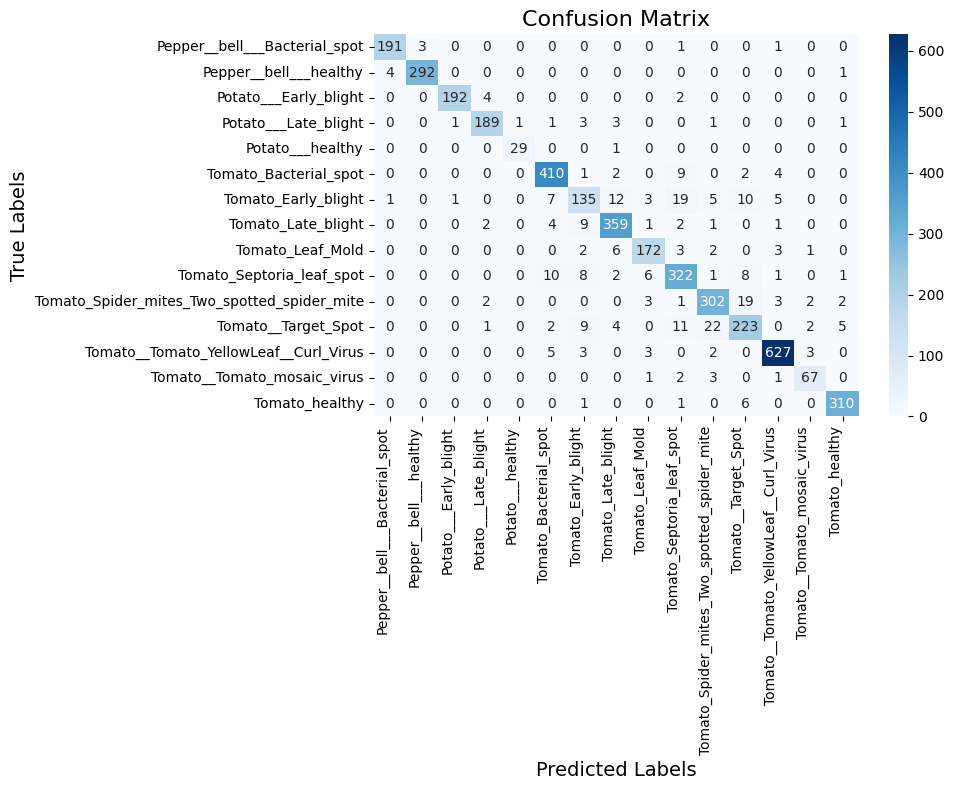


Accuracy: 0.9267

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.97      0.97       196
                     Pepper__bell___healthy       0.99      0.98      0.99       297
                      Potato___Early_blight       0.99      0.97      0.98       198
                       Potato___Late_blight       0.95      0.94      0.95       200
                           Potato___healthy       0.97      0.97      0.97        30
                      Tomato_Bacterial_spot       0.93      0.96      0.95       428
                        Tomato_Early_blight       0.79      0.68      0.73       198
                         Tomato_Late_blight       0.92      0.95      0.93       379
                           Tomato_Leaf_Mold       0.91      0.91      0.91       189
                  Tomato_Septoria_leaf_spot       0.86      0.90      0.88       359
Tomato_Spider_mites_Tw

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import seaborn as sns

# Get class labels
class_labels = list(val_generator.class_indices.keys())

y_true = []
y_pred = []

for images, labels in val_generator:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))
    
    # Stop when all validation data is processed
    if len(y_true) >= val_generator.samples:
        break

conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


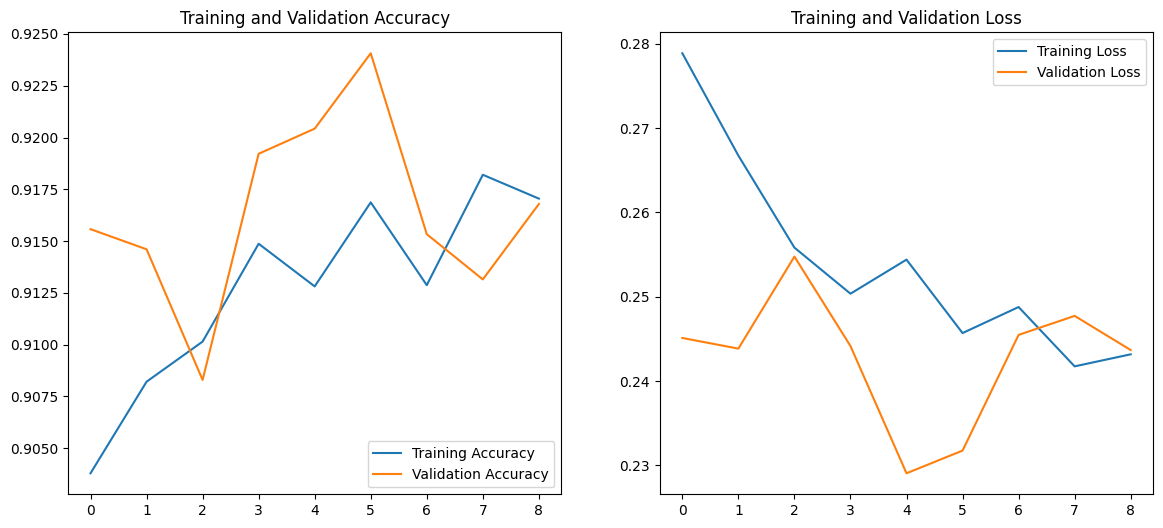

In [48]:
import matplotlib.pyplot as plt

# Combine both histories if needed
def plot_training_history(histories, titles):
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    
    for h in histories:
        acc += h.history['accuracy']
        val_acc += h.history['val_accuracy']
        loss += h.history['loss']
        val_loss += h.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

# Plot
plot_training_history([history_fine], ["Fine-Tuning"])
